### Installs & Imports

In [ ]:
!pip install --upgrade pip

!pip install emoji langdetect nltk scikit-learn pandas numpy spacy simpletransformers \
    seaborn matplotlib pickle5 gensim cython vaderSentiment

!pip uninstall numpy gensim -y
!pip install --no-cache-dir numpy gensim


In [2]:
import nltk
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('averaged_perceptron_tagger')
nltk.download('vader_lexicon')


# System & Utility Libraries
import os
import json
import re
import pickle
import string
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from collections import Counter
from io import StringIO

# NLTK & NLP Libraries
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.util import ngrams
from nltk.stem import WordNetLemmatizer
from nltk import pos_tag
from nltk.sentiment.vader import SentimentIntensityAnalyzer

# Spacy NLP
import spacy
from spacy.tokens import Doc

# Scikit-learn & ML Libraries
from sklearn.feature_extraction import DictVectorizer
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.utils.class_weight import compute_class_weight
from sklearn import svm
from sklearn.metrics import classification_report, precision_score, recall_score, f1_score

# Language Detection
from langdetect import detect, DetectorFactory
from langdetect.lang_detect_exception import LangDetectException

# Emoji Handling
import emoji

# SimpleTransformers for Deep Learning Models
from simpletransformers.classification import ClassificationModel, ClassificationArgs



from gensim.models.phrases import Phrases, Phraser


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.
[nltk_data] Downloading package vader_lexicon to /root/nltk_data...


# 1. Named Entity Recognition & Classification

### Training & Validation Sets

#### Distribution Analysis

In [ ]:
label_mapping = {
    0: 'O', 1: 'B-CARDINAL', 2: 'B-DATE', 3: 'I-DATE', 4: 'B-PERSON', 5: 'I-PERSON',
    6: 'B-NORP', 7: 'B-GPE', 8: 'I-GPE', 9: 'B-LAW', 10: 'I-LAW', 11: 'B-ORG',
    12: 'I-ORG', 13: 'B-PERCENT', 14: 'I-PERCENT', 15: 'B-ORDINAL', 16: 'B-MONEY',
    17: 'I-MONEY', 18: 'B-WORK_OF_ART', 19: 'I-WORK_OF_ART', 20: 'B-FAC',
    21: 'B-TIME', 22: 'I-CARDINAL', 23: 'B-LOC', 24: 'B-QUANTITY', 25: 'I-QUANTITY',
    26: 'I-NORP', 27: 'I-LOC', 28: 'B-PRODUCT', 29: 'I-TIME', 30: 'B-EVENT',
    31: 'I-EVENT', 32: 'I-FAC', 33: 'B-LANGUAGE', 34: 'I-PRODUCT', 35: 'I-ORDINAL',
    36: 'I-LANGUAGE'
}

In [ ]:
# Training data (merge 5 files together - we use the original four training files and valiadation as training data)
# # a new file called 'merged_word_train_val' is created as a result of the merging and conversion of
# sentence instances to word instances and is saved in the folder
train_val_files = ["Training Data/NERC Data/Original/train00.json", "Training Data/NERC Data/Original/train01.json", "Training Data/NERC Data/Original/train02.json",
                    "Training Data/NERC Data/Original/train03.json", "Training Data/NERC Data/Original/valid.json"]

output_file = "Training Data/NERC Data/merged_word_train_val.json"

word_instances = []
sentence_id = 0

for file in train_val_files:
    with open(file, "r", encoding="utf-8") as in_file:
        for line in in_file:
            sentence = json.loads(line)
            tokens = sentence["tokens"]
            ner_tags = sentence["tags"]

            for token_id, (token, ner_tag) in enumerate(zip(tokens, ner_tags)):
                word_instance = {
                    "sentence_id": sentence_id,
                    "token_id": token_id,
                    "token": token,
                    "BIO_NER_tag": label_mapping.get(ner_tag, "O")  # Map numeric tag to IOB format
                }
                word_instances.append(word_instance)

            # Increment the sentence ID
            sentence_id += 1

# Save the transformed data to a new JSON file
with open(output_file, "w", encoding="utf-8") as out_file:
    for instance in word_instances:
        out_file.write(json.dumps(instance) + "\n")

In [ ]:
# Validation data (we use the original test data as validation data)
# a new file called 'merged_word_test' is created as a result of the merging and conversion of
# sentence instances to word instances and is saved in the folder
test_file = "Training Data/NERC Data/Original/test.json"
output_file = "Training Data/NERC Data/word_test.json"

word_instances = []
sentence_id = 0

with open(test_file, "r", encoding="utf-8") as in_file:
    for line in in_file:
            sentence = json.loads(line)
            tokens = sentence["tokens"]
            ner_tags = sentence["tags"]

            # Convert sentence instances to word instances
            for token_id, (token, ner_tag) in enumerate(zip(tokens, ner_tags)):
                word_instance = {
                    "sentence_id": sentence_id,
                    "token_id": token_id,
                    "token": token,
                    "BIO_NER_tag": label_mapping.get(ner_tag, "O")  # Map numeric tag to IOB format
                }
                word_instances.append(word_instance)

            # Increment the sentence ID
            sentence_id += 1

# Save the transformed data to a new JSON file
with open(output_file, "w", encoding="utf-8") as out_file:
    for instance in word_instances:
        out_file.write(json.dumps(instance) + "\n")


In [ ]:
def ner_distribution_table(file_path):
    """
    Creates a dataframe showing the count and percentage of each NER tag
    in the given dataset.
    """
    tags_list = []

    with open(file_path, 'r', encoding='utf-8') as f:
        for line in f:
            data = json.loads(line)
            tags_list.append(data['BIO_NER_tag'])

    # Count occurrences of each tag
    tag_counts = Counter(tags_list)

    # Convert counts to percentages
    total_tags = sum(tag_counts.values())
    tag_data = []
    for tag, count in tag_counts.items():
        tag_percentage = (count / total_tags) * 100
        tag_info = {"NER Label": tag, "Count": count, "Percentage": tag_percentage}
        tag_data.append(tag_info)

    # Create and return DataFrame
    df = pd.DataFrame(tag_data).sort_values(by="Percentage", ascending=False)
    df.reset_index(drop=True, inplace=True)
    df = df.set_index(keys="NER Label")

    return df

In [ ]:
train_dtable = ner_distribution_table("Training Data/NERC Data/merged_word_train_val.json")
print(f"Number of instances in training data: {train_dtable["Count"].sum()}")
display(train_dtable)

Number of instances in training data: 1236160


,Count,Percentage
NER Label,,
O,1066810,86.300317
I-ORG,20582,1.664995
B-GPE,17673,1.429669
B-PERSON,17449,1.411549
I-DATE,15142,1.224922
B-ORG,14560,1.177841
I-PERSON,12542,1.014594
B-DATE,12429,1.005452
B-CARDINAL,8292,0.670787


In [ ]:
val_dtable = ner_distribution_table("Training Data/NERC Data/word_test.json")
print(f"Number of instances in validation data: {val_dtable["Count"].sum()}")
display(val_dtable)

Number of instances in validation data: 152723


,Count,Percentage
NER Label,,
O,131814,86.309200
I-ORG,2406,1.575401
B-GPE,2240,1.466708
I-DATE,2011,1.316763
B-PERSON,1988,1.301703
B-ORG,1795,1.175331
B-DATE,1602,1.048958
I-PERSON,1412,0.924550
B-CARDINAL,935,0.612220


### Test Set

In [ ]:
# Distribution of provided Test set (from .tsv file)
file_path = 'Test Data/NER-test.tsv'
test_data_df = pd.read_csv(file_path, delimiter='\t')

# Count occurrences of each tag
tag_counts = Counter(test_data_df['BIO_NER_tag'])

# Convert counts to percentages
total_tags = sum(tag_counts.values())
tag_data = []
for tag, count in tag_counts.items():
    tag_percentage = (count / total_tags) * 100
    tag_info = {"NER Label": tag, "Count": count, "Percentage": tag_percentage}
    tag_data.append(tag_info)

# Create and return DataFrame
distribution_df = pd.DataFrame(tag_data).sort_values(by="Percentage", ascending=False)
distribution_df.reset_index(drop=True, inplace=True)
distribution_df = distribution_df.set_index(keys="NER Label")

print(f"Number of instances in test data: {distribution_df["Count"].sum()}")
display(distribution_df)

Number of instances in test data: 237


,Count,Percentage
NER Label,,
O,186,78.481013
B-PERSON,11,4.641350
I-WORK_OF_ART,10,4.219409
B-WORK_OF_ART,9,3.797468
I-PERSON,8,3.375527
B-LOC,7,2.953586
B-ORG,3,1.265823
I-ORG,2,0.843882
I-LOC,1,0.421941


### Feature Engineering

In [ ]:
def get_shape(word):
    """
    Helper function that determines the shape of word.
    Inspired by the categories for shape in dataset ner_v2.csv used in Lab 4.
    """
    if word in ["__START1__", "__START2__", "__END1__", "__END2__"]:
        return "wildcard"
    elif word in string.punctuation:
        return "punctuation"
    elif "-" in word:
        return "contains-hyphen"
    elif "'" in word:
        return "other"
    elif "." in word and word.isupper():
            return "abbreviation"
    elif word.endswith(".") and word[:-1].isalpha():
        return "ending-dot"
    elif re.match(r'^[A-Z][a-z]+[A-Z][a-z]*$', word):
        return "camelcase"
    elif re.match(r'^(?=.*[a-z])(?=.*[A-Z])', word):
        return "mixedcase"
    elif word.isalpha():
        if word.istitle():
            return "capitalized"
        elif word.islower():
            return "lowercase"
        elif word.isupper():
            return "uppercase"
        else:
            return "other"
    elif word.isdigit():
        return "number"
    else:
        return "other"

In [ ]:
def data_to_features(df, nlp):
    """
     Process a dataframe by adding linguistic features using spaCy.
    - Adds POS tagging, lemmatization and shape features
    - Computes previous, before previous, next, and after next token and their lemma, POS tag and shape
    """
    # Add the POS tags and lemmas
    tokens = df["token"].to_list()
    document = Doc(nlp.vocab, words=tokens)

    # Manually run the tokens through the spaCy pipeline to avoid retokenization
    document = nlp.get_pipe("tok2vec")(document)
    document = nlp.get_pipe("tagger")(document)
    document = nlp.get_pipe("attribute_ruler")(document)
    document = nlp.get_pipe("lemmatizer")(document)

    pos_tags = []
    lemmas = []
    for token in document:
        pos_tags.append(token.tag_)
        lemmas.append(token.lemma_)

    df["POS_tag"] = pos_tags
    df["lemma"] = lemmas

    # Add the previous and next token, their lemmas and their POS tags
    df["prev_token"] = df["token"].shift(1).fillna("__START1__")
    df["prev_prev_token"] = df["token"].shift(2).fillna("__START2__")
    df["next_token"] = df["token"].shift(-1).fillna("__END1__")
    df["next_next_token"] = df["token"].shift(-2).fillna("__END2__")
    df["prev_lemma"] = df["lemma"].shift(1).fillna("__START1__")
    df["prev_prev_lemma"] = df["lemma"].shift(2).fillna("__START2__")
    df["next_lemma"] = df["lemma"].shift(-1).fillna("__END1__")
    df["next_next_lemma"] = df["lemma"].shift(-2).fillna("__END2__")
    df["prev_POS_tag"] = df["POS_tag"].shift(1).fillna("__START1__")
    df["prev_prev_POS_tag"] = df["POS_tag"].shift(2).fillna("__START2__")
    df["next_POS_tag"] = df["POS_tag"].shift(-1).fillna("__END1__")
    df["next_next_POS_tag"] = df["POS_tag"].shift(-2).fillna("__END2__")

    # Add the shape of each word
    df["shape"] = df["token"].apply(get_shape)
    df["prev_shape"] = df["prev_token"].apply(get_shape)
    df["next_shape"] = df["next_token"].apply(get_shape)
    df["prev_prev_shape"] = df["prev_prev_token"].apply(get_shape)
    df["next_next_shape"] = df["next_next_token"].apply(get_shape)

    # Reorder the columns
    df = df[["sentence_id", "token_id", "token", "shape",  "POS_tag", "lemma", "BIO_NER_tag",
        "prev_token", "prev_shape", "prev_POS_tag", "prev_lemma", "prev_prev_token", "prev_prev_shape",
        "prev_prev_POS_tag", "prev_prev_lemma", "next_token", "next_shape", "next_POS_tag", "next_lemma",
        "next_next_token", "next_next_shape", "next_next_POS_tag", "next_next_lemma"]]

    return df

In [ ]:
# Put the training and validation data into dataframes
train_data_file = "Training Data/NERC Data/merged_word_train_val.json"
val_data_file = "Training Data/NERC Data/word_test.json"
train_data = []
val_data = []

# Create a dataframe with the training data
with open(train_data_file, "r", encoding="utf-8") as file:
    for line in file:
        train_data.append(json.loads(line))
train_data_df = pd.read_json(StringIO(json.dumps(train_data)))

# Create a dataframe with the validation data
with open(val_data_file, "r", encoding="utf-8") as file:
    for line in file:
        val_data.append(json.loads(line))
val_data_df = pd.read_json(StringIO(json.dumps(val_data)))

In [ ]:
# Load English model for POS tagging
nlp = spacy.load("en_core_web_sm", disable=["ner", "parser"])
nlp.max_length = 7000000  # increase the max length to allow larger inputs

# Create more features from the data
train_data_df = data_to_features(train_data_df, nlp)
val_data_df = data_to_features(val_data_df, nlp)
test_data_df = data_to_features(test_data_df, nlp)

# Save the files with the features
train_data_df.to_csv("Training Data/NERC Data/train_features.csv", index=False, encoding="utf-8")
val_data_df.to_csv("Training Data/NERC Data/val_features.csv", index=False, encoding="utf-8")
test_data_df.to_csv("Test Data/NER_test_features.csv", index=False, encoding="utf-8")

In [ ]:
# Loading from file, so previous cells do not have to be rerun every time
train_data_df = pd.read_csv("Training Data/NERC Data/train_features.csv", encoding = 'utf-8', keep_default_na=False)
val_data_df = pd.read_csv("Training Data/NERC Data/val_features.csv", encoding = 'utf-8', keep_default_na=False)
test_data_df = pd.read_csv("Test Data/NER_test_features.csv", encoding = 'utf-8', keep_default_na=False)

In [ ]:
def prepare_data_for_vectorization(data, selected_features):
    """

    """
    features = []
    gold_labels = []

    for index, instance in data.iterrows():
        features_dict = {}
        for key, value in instance.items():
            if key in selected_features:
                features_dict[key] = value
            elif key == "BIO_NER_tag":
                ne_label = value

        # Append the features and NE label of the instance
        features.append(features_dict)
        gold_labels.append(ne_label)

    return features, gold_labels

In [ ]:
# Subset of feature used
selected_features_paper = ["token", "shape", "POS_tag", "prev_token", "next_token", "prev_POS_tag", "next_POS_tag", "sentence_id"] # features used in paper
selected_features_chosen = ["sentence_id", "token_id" "token", "shape",  "POS_tag", "lemma",
        "prev_token", "prev_shape", "prev_POS_tag", "prev_lemma", "prev_prev_token", "prev_prev_shape",
        "prev_prev_POS_tag", "prev_prev_lemma", "next_token", "next_shape", "next_POS_tag", "next_lemma",
        "next_next_token", "next_next_shape", "next_next_POS_tag", "next_next_lemma"]

# Prepare the data for vectorization
ner_train_features_paper, ner_train_gold_labels_paper = prepare_data_for_vectorization(train_data_df, selected_features_paper)
ner_val_features_paper, ner_val_gold_labels_paper = prepare_data_for_vectorization(val_data_df, selected_features_paper)
ner_test_features_paper, ner_test_gold_labels_paper = prepare_data_for_vectorization(test_data_df, selected_features_paper)

ner_train_features_chosen, ner_train_gold_labels_chosen = prepare_data_for_vectorization(train_data_df, selected_features_chosen)
ner_val_features_chosen, ner_val_gold_labels_chosen = prepare_data_for_vectorization(val_data_df, selected_features_chosen)
ner_test_features_chosen, ner_test_gold_labels_chosen = prepare_data_for_vectorization(test_data_df, selected_features_chosen)

In [ ]:
# Check for the selected_features_paper
print("Sample Training Feature:", ner_train_features_paper[21])
print("Sample Training Label:", ner_train_gold_labels_paper[21])
print("Sample Validation Feature:", ner_val_features_paper[11])
print("Sample Validation Label:", ner_val_gold_labels_paper[11])
print("Sample Test Feature:", ner_test_features_paper[19])
print("Sample Test Label:", ner_test_gold_labels_paper[19])

Sample Training Feature: {'sentence_id': 1, 'token': 'one', 'shape': 'lowercase', 'POS_tag': 'CD', 'prev_token': 'rarely', 'prev_POS_tag': 'RB', 'next_token': 'of', 'next_POS_tag': 'IN'}
Sample Training Label: B-CARDINAL
Sample Validation Feature: {'sentence_id': 0, 'token': 'U.S.', 'shape': 'abbreviation', 'POS_tag': 'NNP', 'prev_token': 'the', 'prev_POS_tag': 'DT', 'next_token': 'and', 'next_POS_tag': 'CC'}
Sample Validation Label: B-GPE
Sample Test Feature: {'sentence_id': 1, 'token': 'Elena', 'shape': 'mixedcase', 'POS_tag': 'NNP', 'prev_token': '.', 'prev_POS_tag': '.', 'next_token': 'and', 'next_POS_tag': 'CC'}
Sample Test Label: B-PERSON


In [ ]:
# Check for the selected_features_chosen
print("Sample Training Feature:", ner_train_features_chosen[21])
print("Sample Training Label:", ner_train_gold_labels_chosen[21])
print("Sample Validation Feature:", ner_val_features_chosen[11])
print("Sample Validation Label:", ner_val_gold_labels_chosen[11])
print("Sample Test Feature:", ner_test_features_chosen[19])
print("Sample Test Label:", ner_test_gold_labels_chosen[19])

Sample Training Feature: {'sentence_id': 1, 'shape': 'lowercase', 'POS_tag': 'CD', 'lemma': 'one', 'prev_token': 'rarely', 'prev_shape': 'lowercase', 'prev_POS_tag': 'RB', 'prev_lemma': 'rarely', 'prev_prev_token': 'is', 'prev_prev_shape': 'lowercase', 'prev_prev_POS_tag': 'VBZ', 'prev_prev_lemma': 'be', 'next_token': 'of', 'next_shape': 'lowercase', 'next_POS_tag': 'IN', 'next_lemma': 'of', 'next_next_token': 'them', 'next_next_shape': 'lowercase', 'next_next_POS_tag': 'PRP', 'next_next_lemma': 'they'}
Sample Training Label: B-CARDINAL
Sample Validation Feature: {'sentence_id': 0, 'shape': 'abbreviation', 'POS_tag': 'NNP', 'lemma': 'U.S.', 'prev_token': 'the', 'prev_shape': 'lowercase', 'prev_POS_tag': 'DT', 'prev_lemma': 'the', 'prev_prev_token': 'in', 'prev_prev_shape': 'lowercase', 'prev_prev_POS_tag': 'IN', 'prev_prev_lemma': 'in', 'next_token': 'and', 'next_shape': 'lowercase', 'next_POS_tag': 'CC', 'next_lemma': 'and', 'next_next_token': 'non-U.S.', 'next_next_shape': 'contains-

In [ ]:
# Check the number of instances in the training, validation, and test data for selected_features_paper
num_ner_train_instances_paper = len(ner_train_features_paper)
num_ner_val_instances_paper = len(ner_val_features_paper)
num_ner_test_instances_paper = len(ner_test_features_paper)

print(f"Number of instances in training data: {num_ner_train_instances_paper}")
print(f"Number of instances in validation data: {num_ner_val_instances_paper}")
print(f"Number of instances in test data: {num_ner_test_instances_paper}")

Number of instances in training data: 1236160
Number of instances in validation data: 152723
Number of instances in test data: 237


In [ ]:
# Check the number of instances in the training, validation, and test data for selected_features_chosen
num_ner_train_instances_chosen = len(ner_train_features_chosen)
num_ner_val_instances_chosen = len(ner_val_features_chosen)
num_ner_test_instances_chosen = len(ner_test_features_chosen)

print(f"Number of instances in training data: {num_ner_train_instances_chosen}")
print(f"Number of instances in validation data: {num_ner_val_instances_chosen}")
print(f"Number of instances in test data: {num_ner_test_instances_chosen}")

Number of instances in training data: 1236160
Number of instances in validation data: 152723
Number of instances in test data: 237


In [ ]:
 # Concatenate the features lists of selected_features_paper and transform them to one hot encoding using DictVectorizer
vec1 = DictVectorizer()
ner_all_features_paper = ner_train_features_paper + ner_val_features_paper + ner_test_features_paper
ner_array_paper = vec1.fit_transform(ner_all_features_paper)

# Split the features into train, validation, and test lists again
ner_train_features_array_paper = ner_array_paper[:num_ner_train_instances_paper]
ner_val_features_array_paper = ner_array_paper[num_ner_train_instances_paper:(num_ner_train_instances_paper + num_ner_val_instances_paper)]
ner_test_features_array_paper = ner_array_paper[(num_ner_train_instances_paper + num_ner_val_instances_paper):]

# Check whether split has been done correctly
print("Shape of training features array:", ner_train_features_array_paper.shape)
print("Shape of validation features array:", ner_val_features_array_paper.shape)
print("Shape of test features array:", ner_test_features_array_paper.shape)

Shape of training features array: (1236160, 139908)
Shape of validation features array: (152723, 139908)
Shape of test features array: (237, 139908)


In [ ]:
 # Concatenate the features lists of selected_features_chosen and transform them to one hot encoding using DictVectorizer
vec2 = DictVectorizer()
ner_all_features_chosen = ner_train_features_chosen + ner_val_features_chosen + ner_test_features_chosen
ner_array_chosen = vec2.fit_transform(ner_all_features_chosen)

# Split the features into train, validation, and test lists again
ner_train_features_array_chosen = ner_array_chosen[:num_ner_train_instances_chosen]
ner_val_features_array_chosen = ner_array_chosen[num_ner_train_instances_chosen:(num_ner_train_instances_chosen + num_ner_val_instances_chosen)]
ner_test_features_array_chosen = ner_array_chosen[(num_ner_train_instances_chosen + num_ner_val_instances_chosen):]

# Check whether split has been done correctly
print("Shape of training features array:", ner_train_features_array_chosen.shape)
print("Shape of validation features array:", ner_val_features_array_chosen.shape)
print("Shape of test features array:", ner_test_features_array_chosen.shape)

Shape of training features array: (1236160, 370011)
Shape of validation features array: (152723, 370011)
Shape of test features array: (237, 370011)


### Model Training

In [ ]:
# Initialize the SVM classifier for selected_features_paper
ner_svm_clf_paper = svm.LinearSVC(max_iter=2000, class_weight="balanced", random_state=0)
# Max iterations are set to 2000, which is the same as the referenced paper for NERC

# Train the model on the training data
ner_svm_clf_paper.fit(ner_train_features_array_paper, ner_train_gold_labels_paper)

LinearSVC(class_weight='balanced', max_iter=2000, random_state=0)

In [ ]:
# Evaluate the model on the validation data
ner_val_predictions_paper = ner_svm_clf_paper.predict(ner_val_features_array_paper)
ner_val_report_paper = classification_report(ner_val_gold_labels_paper, ner_val_predictions_paper)

print("Validation Set - Classification Report:")
print(ner_val_report_paper)

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Validation Set - Classification Report:
               precision    recall  f1-score   support

   B-CARDINAL       0.42      0.71      0.52       935
       B-DATE       0.33      0.00      0.00      1602
      B-EVENT       0.13      0.57      0.21        63
        B-FAC       0.08      0.49      0.13       135
        B-GPE       0.54      0.58      0.56      2240
   B-LANGUAGE       0.29      0.64      0.40        22
        B-LAW       0.04      0.28      0.07        40
        B-LOC       0.18      0.63      0.28       179
      B-MONEY       0.37      0.62      0.46       313
       B-NORP       0.21      0.83      0.33       841
    B-ORDINAL       0.41      0.97      0.58       195
        B-ORG       0.28      0.45      0.34      1795
    B-PERCENT       0.63      0.70      0.66       349
     B-PERSON       0.54      0.22      0.32      1988
    B-PRODUCT       0.22      0.54      0.32        76
   B-QUANTITY       0.14      0.69      0.24       105
       B-TIME       0.37

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [ ]:
# Initialize the SVM classifier for selected_features_paper
ner_svm_clf_chosen = svm.LinearSVC(max_iter=2000, class_weight="balanced", random_state=0)
# Max iterations are set to 2000, which is the same as the referenced paper for NERC

# Train the model on the training data
ner_svm_clf_chosen.fit(ner_train_features_array_chosen, ner_train_gold_labels_chosen)

LinearSVC(class_weight='balanced', max_iter=2000, random_state=0)

In [ ]:
# Evaluate the model on the validation data
ner_val_predictions_chosen = ner_svm_clf_chosen.predict(ner_val_features_array_chosen)
ner_val_report_chosen = classification_report(ner_val_gold_labels_chosen, ner_val_predictions_chosen)

print("Validation Set - Classification Report:")
print(ner_val_report_chosen)

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Validation Set - Classification Report:
               precision    recall  f1-score   support

   B-CARDINAL       0.45      0.69      0.54       935
       B-DATE       1.00      0.00      0.00      1602
      B-EVENT       0.21      0.62      0.31        63
        B-FAC       0.19      0.44      0.26       135
        B-GPE       0.54      0.32      0.40      2240
   B-LANGUAGE       0.17      0.27      0.21        22
        B-LAW       0.23      0.42      0.30        40
        B-LOC       0.25      0.68      0.36       179
      B-MONEY       0.48      0.89      0.62       313
       B-NORP       0.37      0.84      0.52       841
    B-ORDINAL       0.59      0.96      0.73       195
        B-ORG       0.30      0.58      0.40      1795
    B-PERCENT       0.63      0.97      0.77       349
     B-PERSON       0.53      0.22      0.31      1988
    B-PRODUCT       0.28      0.57      0.38        76
   B-QUANTITY       0.44      0.71      0.54       105
       B-TIME       0.39

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


### Model Evaluation on the Test Set

In [ ]:
# Evaluate the model with selected_features_paper on the validation data
ner_test_predictions_paper = ner_svm_clf_paper.predict(ner_test_features_array_paper)
ner_test_report_paper = classification_report(ner_test_gold_labels_paper, ner_test_predictions_paper)

print("Test Set - Classification Report:")
print(ner_test_report_paper)

Test Set - Classification Report:
               precision    recall  f1-score   support

   B-CARDINAL       0.00      0.00      0.00         0
        B-FAC       0.00      0.00      0.00         0
        B-GPE       0.00      0.00      0.00         0
        B-LOC       0.00      0.00      0.00         7
       B-NORP       0.00      0.00      0.00         0
    B-ORDINAL       0.00      0.00      0.00         0
        B-ORG       0.15      0.67      0.25         3
     B-PERSON       1.00      0.18      0.31        11
B-WORK_OF_ART       1.00      0.44      0.62         9
      I-EVENT       0.00      0.00      0.00         0
        I-FAC       0.00      0.00      0.00         0
        I-GPE       0.00      0.00      0.00         0
        I-LOC       0.00      0.00      0.00         1
        I-ORG       0.00      0.00      0.00         2
     I-PERSON       0.75      0.38      0.50         8
I-WORK_OF_ART       0.60      0.30      0.40        10
            O       0.99      

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_pr

In [ ]:
# Evaluate the model with selected_features_chosen on the validation data
ner_test_predictions_chosen = ner_svm_clf_chosen.predict(ner_test_features_array_chosen)
ner_test_report_chosen = classification_report(ner_test_gold_labels_chosen, ner_test_predictions_chosen)

print("Test Set - Classification Report:")
print(ner_test_report_chosen)

Test Set - Classification Report:
               precision    recall  f1-score   support

   B-CARDINAL       0.00      0.00      0.00         0
        B-FAC       0.00      0.00      0.00         0
        B-GPE       0.00      0.00      0.00         0
        B-LOC       0.00      0.00      0.00         7
       B-NORP       0.00      0.00      0.00         0
    B-ORDINAL       0.00      0.00      0.00         0
        B-ORG       0.25      1.00      0.40         3
     B-PERSON       1.00      0.27      0.43        11
B-WORK_OF_ART       1.00      0.56      0.71         9
        I-FAC       0.00      0.00      0.00         0
        I-GPE       0.00      0.00      0.00         0
        I-LOC       0.00      0.00      0.00         1
        I-ORG       0.00      0.00      0.00         2
     I-PERSON       0.80      1.00      0.89         8
I-WORK_OF_ART       0.78      0.70      0.74        10
            O       0.98      0.95      0.96       186

     accuracy                

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_pr

# 2. Sentiment Analysis

### Training & Validation Sets

In [ ]:
#MERGING the original train and val to use together as training
train_df = pd.read_csv("Training Data/Sentiment Analysis Data/train_df.csv")
val_df = pd.read_csv("Training Data/Sentiment Analysis Data/val_df.csv")

#merge
merged_df = pd.concat([train_df, val_df], ignore_index=True)

#save in new csv file
merged_df.to_csv("Training Data/Sentiment Analysis Data/merged_new_train.csv", index=False)

In [ ]:
#CLEANING and saving to new files (cleaned_train; cleaned_val)
def clean_sentiment(text):
    text = str(text)
    #convert to lowercase
    text = text.lower()
    #remove URLs
    text = re.sub(r"http\S+|www\S+", "", text)
    #remove mentions and hastags
    text = re.sub(r"@\w+|#\w+", "", text)
    #remove special characters (punctuation still there)
    text = re.sub(r"[^a-zA-Z0-9\s.,!?']", "", text)
    #remove spaces
    text = re.sub(r'\s+', ' ', text).strip()
    #optional: remove emojis, replace them with text
    #text = emoji.demojize(text, delimiters=(" ", " ")) ###TBC!
    return text

training_data = pd.read_csv("Training Data/Sentiment Analysis Data/merged_new_train.csv")
training_data["text"] = training_data["text"].apply(clean_sentiment)
training_data.to_csv("Training Data/Sentiment Analysis Data/cleaned_train.csv", index=False)


val_data = pd.read_csv("Training Data/Sentiment Analysis Data/new_val.csv")
val_data["text"] = val_data["text"].apply(clean_sentiment)
val_data.to_csv("Training Data/Sentiment Analysis Data/cleaned_val.csv", index=False)

#### Distribution Analysis

In [23]:
def visualize_sentiment_distribution(file_path):
    '''
        TBA
    '''
    df = pd.read_csv(file_path)
    sentiment_counts = Counter(df['sentiment'])

    total_labels = sum(sentiment_counts.values())
    sentiment_percentages = {label: (count / total_labels) * 100 for label, count in sentiment_counts.items()}

    sorted_labels = sorted(sentiment_percentages.items(), key=lambda x: x[1], reverse=True)
    labels, percentages = zip(*sorted_labels)
    color_map = {"neutral": "#FFE119", "positive": "#F032E6", "negative": "#46F0F0"}
    colors = [color_map[label] for label in labels]

    # Create the bar chart (horizontal)
    plt.figure(figsize=(8, 5))
    sns.barplot(y=labels, x=percentages, hue=labels, palette=colors, legend=False)
    for index, value in enumerate(percentages):
        plt.text(value + 0.2, index, f'{value:.2f}%', va='center', fontsize=9)
    plt.xlabel('Percentage (%)')
    plt.ylabel('Label')
    plt.xlim(0, 45)
    filename = os.path.basename(file_path)
    plt.title(f'Distribution of Sentiment Labels in {filename}')
    plt.show()

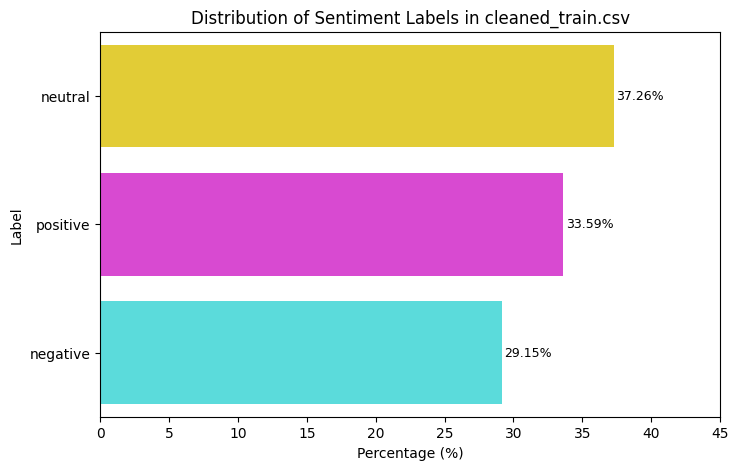

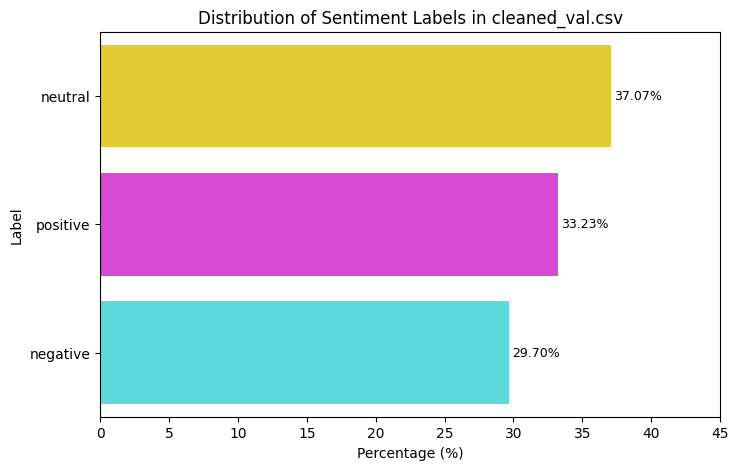

In [24]:
# Old files
# files = ['Training Data/Sentiment Analysis Data/train_df.csv', 'Training Data/Sentiment Analysis Data/val_df.csv', 'Training Data/Sentiment Analysis Data/test_df.csv']

# New (cleaned+merged) files
#files = ['Training Data/Sentiment Analysis Data/cleaned_train.csv', 'Training Data/Sentiment Analysis Data/cleaned_val.csv']
# for colab:
files = ['cleaned_train.csv', 'cleaned_val.csv']

for file in files:
    visualize_sentiment_distribution(file)

### Test Set (the same test set is used for both sentiment analysis and topic modeling)

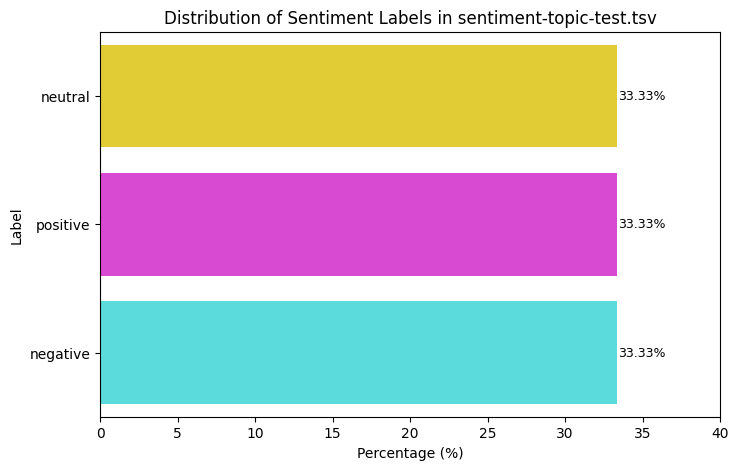

In [ ]:
# Distribution of provided Test set (from .tsv file)
file_path = 'Test Data/sentiment-topic-test.tsv'
df = pd.read_csv(file_path, delimiter='\t')

sentiment_counts = Counter(df['sentiment'])

total_labels = sum(sentiment_counts.values())
sentiment_percentages = {label: (count / total_labels) * 100 for label, count in sentiment_counts.items()}

ordered_labels = ["neutral", "positive", "negative"]
percentages = [sentiment_percentages[label] for label in ordered_labels]
color_map = {"neutral": "#FFE119", "positive": "#F032E6", "negative": "#46F0F0"}
colors = [color_map[label] for label in ordered_labels]

# Create the bar chart (horizontal)
plt.figure(figsize=(8,5))
sns.barplot(y=ordered_labels, x=percentages, hue=ordered_labels, palette=colors, legend=False)
for index, value in enumerate(percentages):
    plt.text(value + 0.1, index, f'{value:.2f}%', va='center', fontsize=9)
plt.xlabel('Percentage (%)')
plt.ylabel('Label')
plt.xlim(0, 40)
filename = os.path.basename(file_path)
plt.title(f'Distribution of Sentiment Labels in {filename}')
plt.show()

### VADER on Test Set

In [ ]:
nlp = spacy.load("en_core_web_sm")
vader_model = SentimentIntensityAnalyzer()

def vader_output_to_label(vader_output):
    """
    Convert VADER's compound score to sentiment labels.
    """
    compound = vader_output['compound']

    if compound < 0:
        return 'negative'
    elif compound == 0.0:
        return 'neutral'
    else:
        return 'positive'

# There is an option to turn on and off preprocessing of VADER input (preprocess=False/True).
# Without preprocessing, the performance increases, but it isn't a huge change in terms of number of misclassified sentences.
def run_vader(textual_unit, lemmatize=False, parts_of_speech_to_consider=None, verbose=False, preprocess=False):
    """
    Run VADER on a sentence with optional lemmatization and POS filtering.

    Params:
        preprocess - enables or disables spaCy preprocessing before passing a sentence to VADER
    """
    if preprocess == True:
        doc = nlp(textual_unit)
        input_to_vader = []

        for sent in doc.sents:
            for token in sent:
                to_add = token.text
                if lemmatize:
                    to_add = token.lemma_
                    if to_add == '-PRON-':
                        to_add = token.text
                if parts_of_speech_to_consider:
                    if token.pos_ in parts_of_speech_to_consider:
                        input_to_vader.append(to_add)
                else:
                    input_to_vader.append(to_add)

        scores = vader_model.polarity_scores(' '.join(input_to_vader))

        if verbose >= 1:
            print("\nINPUT SENTENCE:", textual_unit)
            print("INPUT TO VADER:", input_to_vader)
            print("VADER OUTPUT:", scores)
    else:
        scores = vader_model.polarity_scores(textual_unit)

        if verbose >= 1:
            print("\nINPUT SENTENCE:", textual_unit)
            print("VADER OUTPUT:", scores)

    return scores

def evaluate_vader_on_testset(file_path, lemmatize=False, parts_of_speech_to_consider=None, verbose=False, preprocess=False, print_report=False, misclassification_breakdown=False):
    """
    Run VADER on the test set and compare with ground truth sentiment labels.
    """
    df = pd.read_csv(file_path, delimiter="\t")

    # Dictionaries to store error counts and details for misclassified sentences
    misclassified_counts = {"positive": 0, "negative": 0, "neutral": 0}
    misclassified_sentences = {"positive": [], "negative": [], "neutral": []}

    actual_sentiments = df["sentiment"].tolist()
    sentences = df["sentence"].tolist()

    predicted_sentiments = []

    # Run VADER
    for i in range(len(sentences)):
        vader_output = run_vader(sentences[i], lemmatize=lemmatize, parts_of_speech_to_consider=parts_of_speech_to_consider, verbose=verbose, preprocess=preprocess)
        predicted_label = vader_output_to_label(vader_output)
        predicted_sentiments.append(predicted_label)

        true_label = actual_sentiments[i]

        # Check for misclassification
        if true_label != predicted_label:
            misclassified_counts[true_label] += 1
            misclassified_sentences[true_label].append((sentences[i], predicted_label, vader_output))

    # If the option is selected, show detailed misclassification breakdown
    if misclassification_breakdown == True:
        print("\nMisclassification Summary")
        print("-" * 50)
        for sentiment, count in misclassified_counts.items():
            print(f"{sentiment.capitalize()} misclassified: {count}")
        print("=" * 50)
        for sentiment, errors in misclassified_sentences.items():
            print(f"\nMisclassified {sentiment.capitalize()} Sentences")
            print("~" * 50)
            for sentence, predicted, vader_scores in errors:
                print(f"\nSentence: {sentence}")
                print(f"Expected: {sentiment}; Predicted: {predicted}")
                print(f"VADER Scores: {vader_scores}")
                print("*" * 50)

    # If the option is selected, show classification report
    if print_report == True:
        print("\nVADER Sentiment Analysis Performance:")
        print(classification_report(actual_sentiments, predicted_sentiments))

In [ ]:
# First print only classification report for better visibility
df_vader_results = evaluate_vader_on_testset(file_path='Test Data/sentiment-topic-test.tsv', lemmatize=False, parts_of_speech_to_consider=None,
                                             verbose=False, preprocess=False, print_report=True, misclassification_breakdown=False)

# Run again with detailed breakdown of misclassifications for detailed analysis, if needed
df_vader_results = evaluate_vader_on_testset(file_path='Test Data/sentiment-topic-test.tsv', lemmatize=False, parts_of_speech_to_consider=None,
                                             verbose=False, preprocess=False, print_report=False, misclassification_breakdown=True)


VADER Sentiment Analysis Performance:
              precision    recall  f1-score   support

    negative       0.00      0.00      0.00         6
     neutral       0.33      0.50      0.40         6
    positive       0.43      0.50      0.46         6

    accuracy                           0.33        18
   macro avg       0.25      0.33      0.29        18
weighted avg       0.25      0.33      0.29        18


Misclassification Summary
--------------------------------------------------
Positive misclassified: 3
Negative misclassified: 6
Neutral misclassified: 3

Misclassified Positive Sentences
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

Sentence: The atmosphere at the stadium tonight was electric.
Expected: positive; Predicted: neutral
VADER Scores: {'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound': 0.0}
**************************************************

Sentence: It had me hooked from the first chapter.
Expected: positive; Predicted: neutral
VADER Scores: {'neg': 0.0, '

### BERT on Test Set

In [4]:
#THIS PART SUGGESTED TO RUN IN COLAB
#Import files there
from google.colab import files
uploaded = files.upload()

Saving sentiment-topic-test.tsv to sentiment-topic-test.tsv


In [9]:
#mount drive to store the model and avoid memory issues
from google.colab import drive
drive.mount('/content/drive')

output_dir = "/content/drive/My Drive/BERT_RoBERTa_Models"


os.makedirs(output_dir, exist_ok=True)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [6]:
#read cleaned data locally
#cleaned_train = pd.read_csv("Training Data/Sentiment Analysis Data/cleaned_train.csv", delimiter=",")
#cleaned_val = pd.read_csv("Training Data/Sentiment Analysis Data/cleaned_val.csv", delimiter=",")
#sentiment_test = pd.read_csv("Test Data/sentiment-topic-test.tsv", delimiter="\t")

#read cleaned data on colab
cleaned_train = pd.read_csv("cleaned_train.csv", delimiter=",")
cleaned_val = pd.read_csv("cleaned_val.csv", delimiter=",")
sentiment_test = pd.read_csv("sentiment-topic-test.tsv", delimiter="\t")


#rename columns so they match across all datasets
cleaned_train = cleaned_train[['text', 'sentiment']].rename(columns={'text': 'text', 'sentiment': 'labels'})
cleaned_val = cleaned_val[['text', 'sentiment']].rename(columns={'text': 'text', 'sentiment': 'labels'})
sentiment_test = sentiment_test[['sentence', 'sentiment']].rename(columns={'sentence': 'text', 'sentiment': 'labels'})

#BERT requires numerical labels --> change to 0/1/2
label_map = {'negative': 0, 'neutral': 1, 'positive': 2}

cleaned_train['labels'] = cleaned_train['labels'].map(label_map)
cleaned_val['labels'] = cleaned_val['labels'].map(label_map)
sentiment_test['labels'] = sentiment_test['labels'].map(label_map)


In [12]:
#defining model's configuration
model_args = ClassificationArgs()

model_args.overwrite_output_dir = True  #overwrite any saved models in the output directory
model_args.evaluate_during_training = True  #evaluate during training
model_args.num_train_epochs = 10
model_args.train_batch_size = 32
model_args.learning_rate = 4e-6
model_args.max_seq_length = 512 #increased
model_args.fp16 = True
model_args.gradient_accumulation_steps = 2
model_args.output_dir = output_dir
model_args.best_model_dir = os.path.join(output_dir, "best_model")


model_args.use_early_stopping = True
model_args.early_stopping_delta = 0.01
model_args.early_stopping_metric = 'eval_loss'
model_args.early_stopping_metric_minimize = True
model_args.early_stopping_patience = 5 #increased
model_args.evaluate_during_training_steps = 32


steps_per_epoch = int(np.ceil(len(cleaned_train) / float(model_args.train_batch_size)))
print(f'Each epoch will have {steps_per_epoch} steps.')

Each epoch will have 1139 steps.


In [13]:
#load the model
model = ClassificationModel('bert', 'bert-base-uncased', num_labels=3, args=model_args, use_cuda=True)

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [14]:
_, history = model.train_model(cleaned_train, eval_df=cleaned_val, output_dir=output_dir)

  0%|          | 0/72 [00:00<?, ?it/s]

Epoch:   0%|          | 0/10 [00:00<?, ?it/s]

/usr/local/lib/python3.11/dist-packages/simpletransformers/classification/classification_model.py:882: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = amp.GradScaler()


Running Epoch 1 of 10:   0%|          | 0/1139 [00:00<?, ?it/s]

/usr/local/lib/python3.11/dist-packages/simpletransformers/classification/classification_model.py:905: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast():


  0%|          | 0/10 [00:00<?, ?it/s]

/usr/local/lib/python3.11/dist-packages/simpletransformers/classification/classification_model.py:1505: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast():
/usr/local/lib/python3.11/dist-packages/simpletransformers/classification/classification_model.py:905: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast():


  0%|          | 0/10 [00:00<?, ?it/s]

/usr/local/lib/python3.11/dist-packages/simpletransformers/classification/classification_model.py:1505: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast():
/usr/local/lib/python3.11/dist-packages/simpletransformers/classification/classification_model.py:905: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast():


  0%|          | 0/10 [00:00<?, ?it/s]

/usr/local/lib/python3.11/dist-packages/simpletransformers/classification/classification_model.py:1505: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast():
/usr/local/lib/python3.11/dist-packages/simpletransformers/classification/classification_model.py:905: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast():


  0%|          | 0/10 [00:00<?, ?it/s]

/usr/local/lib/python3.11/dist-packages/simpletransformers/classification/classification_model.py:1505: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast():
/usr/local/lib/python3.11/dist-packages/simpletransformers/classification/classification_model.py:905: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast():


  0%|          | 0/10 [00:00<?, ?it/s]

/usr/local/lib/python3.11/dist-packages/simpletransformers/classification/classification_model.py:1505: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast():
/usr/local/lib/python3.11/dist-packages/simpletransformers/classification/classification_model.py:905: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast():


  0%|          | 0/10 [00:00<?, ?it/s]

/usr/local/lib/python3.11/dist-packages/simpletransformers/classification/classification_model.py:1505: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast():
/usr/local/lib/python3.11/dist-packages/simpletransformers/classification/classification_model.py:905: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast():


  0%|          | 0/10 [00:00<?, ?it/s]

/usr/local/lib/python3.11/dist-packages/simpletransformers/classification/classification_model.py:1505: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast():
/usr/local/lib/python3.11/dist-packages/simpletransformers/classification/classification_model.py:905: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast():


  0%|          | 0/10 [00:00<?, ?it/s]

/usr/local/lib/python3.11/dist-packages/simpletransformers/classification/classification_model.py:1505: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast():
/usr/local/lib/python3.11/dist-packages/simpletransformers/classification/classification_model.py:905: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast():


  0%|          | 0/10 [00:00<?, ?it/s]

/usr/local/lib/python3.11/dist-packages/simpletransformers/classification/classification_model.py:1505: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast():
/usr/local/lib/python3.11/dist-packages/simpletransformers/classification/classification_model.py:905: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast():


  0%|          | 0/10 [00:00<?, ?it/s]

/usr/local/lib/python3.11/dist-packages/simpletransformers/classification/classification_model.py:1505: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast():
/usr/local/lib/python3.11/dist-packages/simpletransformers/classification/classification_model.py:905: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast():


  0%|          | 0/10 [00:00<?, ?it/s]

/usr/local/lib/python3.11/dist-packages/simpletransformers/classification/classification_model.py:1505: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast():
/usr/local/lib/python3.11/dist-packages/simpletransformers/classification/classification_model.py:905: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast():


  0%|          | 0/10 [00:00<?, ?it/s]

/usr/local/lib/python3.11/dist-packages/simpletransformers/classification/classification_model.py:1505: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast():
/usr/local/lib/python3.11/dist-packages/simpletransformers/classification/classification_model.py:905: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast():


  0%|          | 0/10 [00:00<?, ?it/s]

/usr/local/lib/python3.11/dist-packages/simpletransformers/classification/classification_model.py:1505: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast():
/usr/local/lib/python3.11/dist-packages/simpletransformers/classification/classification_model.py:905: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast():


  0%|          | 0/10 [00:00<?, ?it/s]

/usr/local/lib/python3.11/dist-packages/simpletransformers/classification/classification_model.py:1505: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast():
/usr/local/lib/python3.11/dist-packages/simpletransformers/classification/classification_model.py:905: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast():


  0%|          | 0/10 [00:00<?, ?it/s]

/usr/local/lib/python3.11/dist-packages/simpletransformers/classification/classification_model.py:1505: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast():
/usr/local/lib/python3.11/dist-packages/simpletransformers/classification/classification_model.py:905: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast():


  0%|          | 0/10 [00:00<?, ?it/s]

/usr/local/lib/python3.11/dist-packages/simpletransformers/classification/classification_model.py:1505: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast():
/usr/local/lib/python3.11/dist-packages/simpletransformers/classification/classification_model.py:905: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast():


  0%|          | 0/10 [00:00<?, ?it/s]

/usr/local/lib/python3.11/dist-packages/simpletransformers/classification/classification_model.py:1505: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast():
/usr/local/lib/python3.11/dist-packages/simpletransformers/classification/classification_model.py:905: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast():


  0%|          | 0/10 [00:00<?, ?it/s]

/usr/local/lib/python3.11/dist-packages/simpletransformers/classification/classification_model.py:1505: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast():


Running Epoch 2 of 10:   0%|          | 0/1139 [00:00<?, ?it/s]

/usr/local/lib/python3.11/dist-packages/simpletransformers/classification/classification_model.py:905: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast():


  0%|          | 0/10 [00:00<?, ?it/s]

/usr/local/lib/python3.11/dist-packages/simpletransformers/classification/classification_model.py:1505: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast():
/usr/local/lib/python3.11/dist-packages/simpletransformers/classification/classification_model.py:905: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast():


  0%|          | 0/10 [00:00<?, ?it/s]

/usr/local/lib/python3.11/dist-packages/simpletransformers/classification/classification_model.py:1505: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast():
/usr/local/lib/python3.11/dist-packages/simpletransformers/classification/classification_model.py:905: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast():


  0%|          | 0/10 [00:00<?, ?it/s]

/usr/local/lib/python3.11/dist-packages/simpletransformers/classification/classification_model.py:1505: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast():
/usr/local/lib/python3.11/dist-packages/simpletransformers/classification/classification_model.py:905: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast():


  0%|          | 0/10 [00:00<?, ?it/s]

/usr/local/lib/python3.11/dist-packages/simpletransformers/classification/classification_model.py:1505: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast():
/usr/local/lib/python3.11/dist-packages/simpletransformers/classification/classification_model.py:905: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast():


  0%|          | 0/10 [00:00<?, ?it/s]

/usr/local/lib/python3.11/dist-packages/simpletransformers/classification/classification_model.py:1505: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast():
/usr/local/lib/python3.11/dist-packages/simpletransformers/classification/classification_model.py:905: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast():


  0%|          | 0/10 [00:00<?, ?it/s]

/usr/local/lib/python3.11/dist-packages/simpletransformers/classification/classification_model.py:1505: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast():
/usr/local/lib/python3.11/dist-packages/simpletransformers/classification/classification_model.py:905: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast():


  0%|          | 0/10 [00:00<?, ?it/s]

/usr/local/lib/python3.11/dist-packages/simpletransformers/classification/classification_model.py:1505: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast():
/usr/local/lib/python3.11/dist-packages/simpletransformers/classification/classification_model.py:905: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast():


  0%|          | 0/10 [00:00<?, ?it/s]

/usr/local/lib/python3.11/dist-packages/simpletransformers/classification/classification_model.py:1505: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast():
/usr/local/lib/python3.11/dist-packages/simpletransformers/classification/classification_model.py:905: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast():


  0%|          | 0/10 [00:00<?, ?it/s]

/usr/local/lib/python3.11/dist-packages/simpletransformers/classification/classification_model.py:1505: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast():
/usr/local/lib/python3.11/dist-packages/simpletransformers/classification/classification_model.py:905: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast():


  0%|          | 0/10 [00:00<?, ?it/s]

/usr/local/lib/python3.11/dist-packages/simpletransformers/classification/classification_model.py:1505: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast():
/usr/local/lib/python3.11/dist-packages/simpletransformers/classification/classification_model.py:905: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast():


  0%|          | 0/10 [00:00<?, ?it/s]

/usr/local/lib/python3.11/dist-packages/simpletransformers/classification/classification_model.py:1505: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast():
/usr/local/lib/python3.11/dist-packages/simpletransformers/classification/classification_model.py:905: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast():


  0%|          | 0/10 [00:00<?, ?it/s]

/usr/local/lib/python3.11/dist-packages/simpletransformers/classification/classification_model.py:1505: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast():
/usr/local/lib/python3.11/dist-packages/simpletransformers/classification/classification_model.py:905: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast():


  0%|          | 0/10 [00:00<?, ?it/s]

/usr/local/lib/python3.11/dist-packages/simpletransformers/classification/classification_model.py:1505: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast():
/usr/local/lib/python3.11/dist-packages/simpletransformers/classification/classification_model.py:905: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast():


  0%|          | 0/10 [00:00<?, ?it/s]

/usr/local/lib/python3.11/dist-packages/simpletransformers/classification/classification_model.py:1505: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast():
/usr/local/lib/python3.11/dist-packages/simpletransformers/classification/classification_model.py:905: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast():


  0%|          | 0/10 [00:00<?, ?it/s]

/usr/local/lib/python3.11/dist-packages/simpletransformers/classification/classification_model.py:1505: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast():
/usr/local/lib/python3.11/dist-packages/simpletransformers/classification/classification_model.py:905: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast():


  0%|          | 0/10 [00:00<?, ?it/s]

/usr/local/lib/python3.11/dist-packages/simpletransformers/classification/classification_model.py:1505: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast():
/usr/local/lib/python3.11/dist-packages/simpletransformers/classification/classification_model.py:905: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast():


  0%|          | 0/10 [00:00<?, ?it/s]

/usr/local/lib/python3.11/dist-packages/simpletransformers/classification/classification_model.py:1505: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast():
/usr/local/lib/python3.11/dist-packages/simpletransformers/classification/classification_model.py:905: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast():


  0%|          | 0/10 [00:00<?, ?it/s]

/usr/local/lib/python3.11/dist-packages/simpletransformers/classification/classification_model.py:1505: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast():


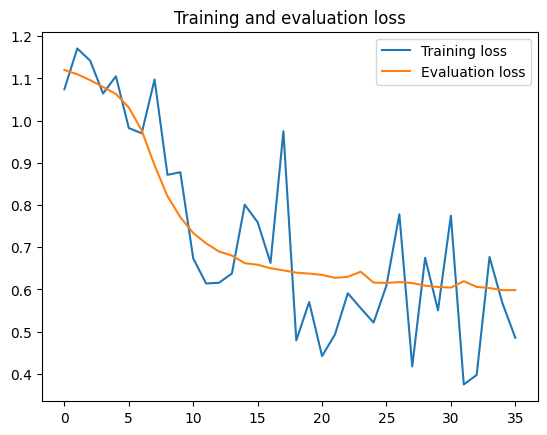

In [15]:
#training and evaluation loss
train_loss = history['train_loss']
eval_loss = history['eval_loss']
plt.plot(train_loss, label='Training loss')
plt.plot(eval_loss, label='Evaluation loss')
plt.title('Training and evaluation loss')
plt.legend()

In [16]:
result, model_outputs, wrong_predictions = model.eval_model(cleaned_val)

  0%|          | 0/10 [00:00<?, ?it/s]

Running Evaluation:   0%|          | 0/53 [00:00<?, ?it/s]

/usr/local/lib/python3.11/dist-packages/simpletransformers/classification/classification_model.py:1505: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast():


In [17]:
predicted, probabilities = model.predict(sentiment_test.text.to_list())
sentiment_test['predicted'] = predicted

0it [00:00, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

/usr/local/lib/python3.11/dist-packages/simpletransformers/classification/classification_model.py:2188: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast():


In [19]:
# Result (note: your result can be different due to randomness in operations)
print(classification_report(sentiment_test['labels'], sentiment_test['predicted']))

              precision    recall  f1-score   support

           0       1.00      0.67      0.80         6
           1       0.83      0.83      0.83         6
           2       0.75      1.00      0.86         6

    accuracy                           0.83        18
   macro avg       0.86      0.83      0.83        18
weighted avg       0.86      0.83      0.83        18



In [20]:
print(sentiment_test.columns)


Index(['text', 'labels', 'predicted'], dtype='object')


In [21]:
#print misclassified examples
misclassified = sentiment_test[sentiment_test['predicted'] != sentiment_test['labels']]
print(misclassified)

                                                 text  labels  predicted
3   It’s more of a slow burn than a page-turner, b...       1          2
16  It's really incredibly impressive to mess up s...       0          2
17  The only way it's helped me is by keeping my t...       0          1


# 3. Topic Classification

### Training & Validation Sets

In [ ]:
# Ensures consistent language detection
DetectorFactory.seed = 0

# Load dataset
train_df_tm = pd.read_csv("Training Data/Topic Classification Data/topic_train.csv")

# Initialize NLP tools
lemmatizer = WordNetLemmatizer()
nlp = spacy.load("en_core_web_sm")

# Function to remove emojis
def remove_emojis(text):
    return emoji.replace_emoji(text, replace="")

# Function to remove all common emoticons
def remove_emoticons(text):
    emoticon_pattern = re.compile(r"""
        (:|;|=|X|8)
        (-|')?
        (\)|D|P|O|o|\(|/|\\|\*|3|\||\]|\[)
        |<3
        |¯\\_\(ツ\)_/¯
        |o_O|O_o|o.o|O.O
        |:-?[\[\]{}()<>]
        |:\'\(|:\'\)
    """, re.VERBOSE)
    return emoticon_pattern.sub('', text)

# Function to normalize text: remove punctuation but keep structure
def normalize_text(text):
    text = text.lower()
    text = re.sub(r'\s+', ' ', text).strip()  # Remove extra spaces
    text = re.sub(r"[^\w\s'-]", "", text)  # Preserve hyphens & apostrophes
    return text

# Function to preserve named entities (e.g., "New York" → "New_York")
def preserve_named_entities(text):
    doc = nlp(text)
    entities = {ent.text for ent in doc.ents}  # Extract named entities
    for entity in entities:
        text = text.replace(entity, entity.replace(" ", "_"))  # Convert to bigram form
    return text

# Function to check if the text is in English
def is_english(text):
    try:
        return detect(text) == 'en'
    except LangDetectException:
        return False  # If detection fails, assume non-English

# Function to count words correctly (avoiding symbols & short tokens)
def count_words(text):
    words = re.findall(r'\b[a-zA-Z]{2,}\b', text)  # Words with at least 2 letters
    return len(words)

# Unified Preprocessing Function
def preprocess_text(text):
    text = remove_emojis(text)
    text = remove_emoticons(text)
    text = normalize_text(text)
    text = preserve_named_entities(text)
    tokens = word_tokenize(text)  # Tokenize
    tokens = [lemmatizer.lemmatize(word) for word in tokens if word.isalnum()]  # Lemmatization
    text = " ".join(tokens)
    return text  # no bigrams yet


In [ ]:
# Apply Preprocessing Pipeline
train_tm_clean = train_df_tm.copy()
train_tm_clean['review'] = train_tm_clean['review'].astype(str)
train_tm_clean['review'] = train_tm_clean['review'].astype(str).map(preprocess_text, na_action='ignore')

# Remove non-English reviews
train_tm_clean = train_tm_clean[train_tm_clean['review'].apply(is_english)]

# Remove meaningless reviews (reviews with less than 3 words)
train_tm_clean = train_tm_clean[train_tm_clean['review'].apply(count_words) > 3]

# Reset index after filtering
train_tm_clean.reset_index(drop=True, inplace=True)

# Save cleaned dataset in the same Training Data folder
train_tm_clean.to_csv("Training Data/Topic Classification Data/train_tm_clean.csv", index=False)

#### Distribution Analysis

In [ ]:
def visualize_topic_distribution(file_path):
    '''
        TBA
    '''
    df = pd.read_csv(file_path)

    topic_counts = Counter(df['label'])

    total_labels = sum(topic_counts.values())
    topic_percentages = {label: (count / total_labels) * 100 for label, count in topic_counts.items()}

    ordered_labels = ["sports", "movie", "book"]
    percentages = [topic_percentages[label] for label in ordered_labels]
    color_map = {"sports": "#0082C8", "movie": "#3CB44B", "book": "#E6194B"}
    colors = [color_map[label] for label in ordered_labels]

    # Create the bar chart (horizontal)
    plt.figure(figsize=(8, 5))
    sns.barplot(y=ordered_labels, x=percentages, hue=ordered_labels, palette=colors, legend=False)
    for index, value in enumerate(percentages):
        plt.text(value + 0.2, index, f'{value:.2f}%', va='center', fontsize=9)
    plt.xlabel('Percentage (%)')
    plt.ylabel('Label')
    plt.xlim(0, 45)
    filename = os.path.basename(file_path)
    plt.title(f'Distribution of Topic Labels in {filename}')
    plt.show()

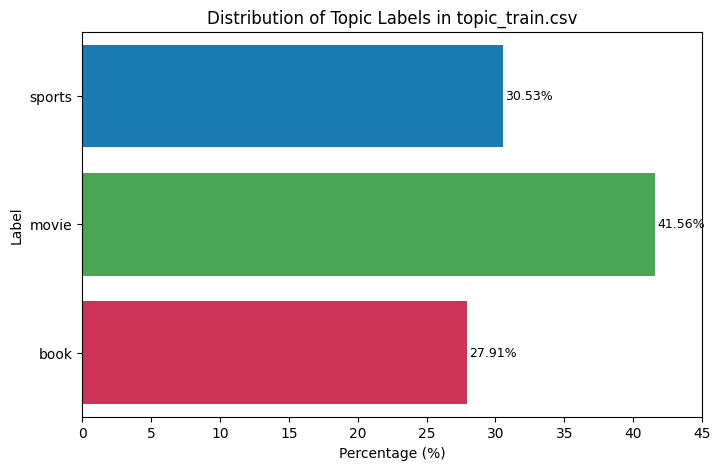

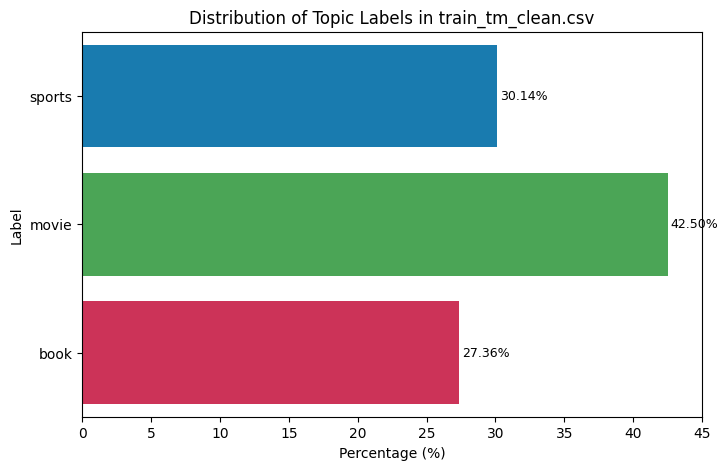

In [ ]:
# This dataset did not come split; therefore, plot the whole thing here, and we can call the vis function for each split after, if we want to plot each part
files = ['Training Data/Topic Classification Data/topic_train.csv', 'Training Data/Topic Classification Data/train_tm_clean.csv']

for file in files:
    visualize_topic_distribution(file)

### Test Set (the same test set is used for both sentiment analysis and topic modeling)

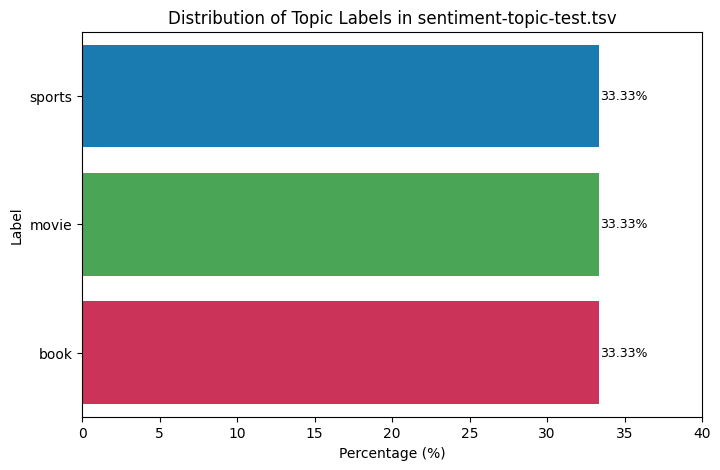

In [ ]:
# Distribution of provided Test set (from .tsv file)
file_path = 'Test Data/sentiment-topic-test.tsv'
df = pd.read_csv(file_path, delimiter='\t')

topic_counts = Counter(df['topic'])

total_labels = sum(topic_counts.values())
topic_percentages = {label: (count / total_labels) * 100 for label, count in topic_counts.items()}

ordered_labels = ["sports", "movie", "book"]
percentages = [topic_percentages[label] for label in ordered_labels]
color_map = {"sports": "#0082C8", "movie": "#3CB44B", "book": "#E6194B"}
colors = [color_map[label] for label in ordered_labels]

# Create the bar chart (horizontal)
plt.figure(figsize=(8, 5))
sns.barplot(y=ordered_labels, x=percentages, hue=ordered_labels, palette=colors, legend=False)
for index, value in enumerate(percentages):
    plt.text(value + 0.1, index, f'{value:.2f}%', va='center', fontsize=9)
plt.xlabel('Percentage (%)')
plt.ylabel('Label')
plt.xlim(0, 40)
filename = os.path.basename(file_path)
plt.title(f'Distribution of Topic Labels in {filename}')
plt.show()

### Feature Engineering

In [ ]:
train_tm_clean = pd.read_csv("Training Data/Topic Classification Data/train_tm_clean.csv")

# Function to tokenize text
def simple_tokenize(text):
    text = text.lower()  # Convert to lowercase
    text = re.sub(r"[^a-z\s]", "", text)  # Remove punctuation, keep spaces
    return text.split()  # Split into words

# Tokenize words from all reviews
all_words = []
for review in train_tm_clean["review"].astype(str):
    all_words.extend(simple_tokenize(review))

# Count word frequencies
word_counts = Counter(all_words)

# Get the most common words
most_common_words = word_counts.most_common(100)

# Convert to DataFrame for easy visualization
common_words_df = pd.DataFrame(most_common_words, columns=["Word", "Frequency"])
pd.set_option("display.max_rows", None)
print(common_words_df.head(100))

         Word  Frequency
0         the     866158
1           a     540147
2         and     435356
3          of     381712
4          to     380675
5          is     277609
6          it     262977
7          in     254645
8           i     244167
9        this     197828
10       that     187913
11        for     134038
12         wa     132893
13       with     119379
14         br     107741
15        but     107665
16      movie      99272
17         on      96253
18        you      93454
19       film      89824
20        not      85721
21        are      81925
22       have      78004
23         he      76004
24        his      74406
25         be      72446
26         at      64341
27        one      61430
28       book      57977
29         by      57695
30         an      57509
31       they      57422
32        all      57050
33       from      55076
34        who      51103
35       like      50716
36         so      50659
37        her      47627
38      there      47276


In [ ]:
stopwords_to_remove = {
    "the", "a", "and", "of", "to", "is", "it", "in", "i", "this", "that", "for", "wa", "with", "but",
    "on", "you", "not", "are", "have", "he", "his", "be", "at", "one", "by", "an", "they", "all",
    "from", "who", "so", "her", "there", "or", "if", "just", "do", "what", "about", "out", "some",
    "more", "very", "my", "she", "when", "would", "can", "their", "get", "up", "had", "even",
    "make", "really", "me", "will", "which", "no", "were", "did", "we", "how", "see", "only",
    "does", "well", "much", "been", "could", "into", "first", "than", "other", "because", "way",
    "also", "after", "most", "him", "them", "thing", "then", "think"
}

# Function to remove these stopwords while keeping domain related words
def remove_stopwords(text):
    words = text.split()
    return " ".join([word for word in words if word not in stopwords_to_remove])

# stopwords removed
train_tm_clean["review"] = train_tm_clean["review"].apply(remove_stopwords)

# Meaningful N-Grams (PMI-Based Bigrams based on the paper)
def build_bigrams(texts):
    """
    Generates meaningful bigrams using PMI-based filtering.
    """
    tokenized_texts = [text.split() for text in texts]
    bigram_model = Phrases(tokenized_texts, min_count=5, threshold=10)
    bigram_phraser = Phraser(bigram_model)
    return [" ".join(bigram_phraser[text]) for text in tokenized_texts]

train_tm_clean["review"] = build_bigrams(train_tm_clean["review"])

train_tm_clean.to_csv("Training Data/Topic Classification Data/train_tm_featured_optimized.csv", index=False)


### Model Training

In [ ]:
# !git clone https://github.com/JoeZJH/Labeled-LDA-Python.git

import sys
sys.path.append("Labeled-LDA-Python/model")
import labeled_lda as llda




In [ ]:
# Load dataset
df = pd.read_csv("Training Data/Topic Classification Data/train_tm_featured_optimized.csv")

# Ensure all reviews are strings and fill NaN values
df["review"] = df["review"].astype(str)

# Convert labels into lists (L-LDA requires lists of topic labels per document)
df["label"] = df["label"].apply(lambda x: [x] if isinstance(x, str) else x)

print(df["label"].head(10))
print(df["label"].isna().sum())


0    [book]
1    [book]
2    [book]
3    [book]
4    [book]
5    [book]
6    [book]
7    [book]
8    [book]
9    [book]
Name: label, dtype: object
0


In [ ]:
# Extract features and labels
X = df["review"].values
y = df["label"].values

# Stratify split to ensure labels are evenly distributed
X_train, X_val, y_train, y_val = train_test_split(
    X, df["label"], test_size=0.2, stratify=y, random_state=8
)

# Reset indices for safe indexing
y_train = y_train.reset_index(drop=True)
y_val = y_val.reset_index(drop=True)

print(y_train.head(10))

0    [sports]
1     [movie]
2     [movie]
3    [sports]
4    [sports]
5     [movie]
6     [movie]
7      [book]
8     [movie]
9    [sports]
Name: label, dtype: object


In [ ]:
# Convert to proper labeled document format for L-LDA
labeled_documents_train = [(X_train[i], y_train.iloc[i]) for i in range(len(X_train))]
labeled_documents_val = [(X_val[i], y_val.iloc[i]) for i in range(len(X_val))]
labeled_documents_train
# labeled_documents_train[0]
# Check number of unique labels in training set
# unique_labels = set(y_train.explode().unique())  # Explode to get all unique topic labels
# print(f"Unique labels in TRAINING set ({len(unique_labels)}): {unique_labels}")
# print(y_train.head(10))


[('organiser accused breaking olympic_bid rule using french embassy prte city madrid 2012 made official protest international_olympic committee 39s ioc ethical commission',
  ['sports']),
 ('kid took movie loved four child age 9 12 year given 10_star emma_robert adorable title_role expect robert future being over exposed like britney_spear paris_hilton refreshing girl look_like worked street enjoyed seeing supporting_cast included tate dvan cameo final takeaway cute filmbr_br note read book series comment based merit film alone',
  ['movie']),
 ('sitting_down watch bachelor wing love knew interesting time watched bachelor passing watching episode two missing find bachelor often appealing intriguing though quality morality often lackingbr_br wing love detail journey taken jake commercial pilot dallas_texas find true love true love find dating show jake meet 25 beautiful girl over country begin know bit mostly superficial know someone conversation jake try true intention known beginning 

In [ ]:
llda_model = llda.LldaModel(labeled_documents=labeled_documents_train, alpha_vector=0.01, eta_vector=0.002)
print(llda_model)


# Train model until convergence
max_iterations = 30

while llda_model.iteration < max_iterations:
    print(f"Iteration {llda_model.iteration + 1} sampling...")
    llda_model.training(10)

    perplexity = llda_model.perplexity()
    delta_beta = llda_model.delta_beta
    print(f"After iteration {llda_model.iteration}, perplexity: {perplexity}")
    print(f"Delta Beta: {delta_beta}")

    # Early stopping criteria
    if delta_beta < 0.05:
        print("Model has converged. Stopping training.")
        break



Labeled-LDA Model:
	K = 3
	M = 94116
	T = 178647
	WN = 5701269
	LN = 0
	alpha = 0.01
	eta = 0.002
	perplexity = 7337.68467469596
	
Iteration 1 sampling...
gibbs sample count:  5701269
gibbs sample count:  5701269
gibbs sample count:  5701269
gibbs sample count:  5701269
gibbs sample count:  5701269
gibbs sample count:  5701269
gibbs sample count:  5701269
gibbs sample count:  5701269
gibbs sample count:  5701269
gibbs sample count:  5701269
After iteration 10, perplexity: 7098.003661450416
Delta Beta: 0.2697306352403127
Iteration 11 sampling...
gibbs sample count:  5701269
gibbs sample count:  5701269
gibbs sample count:  5701269
gibbs sample count:  5701269
gibbs sample count:  5701269
gibbs sample count:  5701269
gibbs sample count:  5701269
gibbs sample count:  5701269
gibbs sample count:  5701269
gibbs sample count:  5701269
After iteration 20, perplexity: 6742.03632834663
Delta Beta: 0.1952942221613779
Iteration 21 sampling...
gibbs sample count:  5701269
gibbs sample count:  570

In [ ]:
# # Compute perplexity on validation set
perplexity_val = llda_model.perplexity(
    documents=[doc for doc, _ in labeled_documents_val],
    iteration=30,
    times=10
)
print(f"Perplexity on validation set: {perplexity_val}")


In [ ]:
y_pred = []
y_true = []

for doc, true_labels in labeled_documents_val:
    predicted_topics = llda_model.inference(document=doc, iteration=30, times=10)
    predicted_labels = [topic[0] for topic in predicted_topics[:len(true_labels)]]

    # Remove "common topic" before storing labels
    true_filtered = [label for label in true_labels if label != "common_topic"]
    pred_filtered = [label for label in predicted_labels if label != "common_topic"]

    # Ensure both lists are of equal length
    if len(true_filtered) == len(pred_filtered):
        y_true.append(true_filtered)
        y_pred.append(pred_filtered)

# Flatten lists to match sklearn format
y_true_flat = [label for sublist in y_true for label in sublist]
y_pred_flat = [label for sublist in y_pred for label in sublist]

if len(y_true_flat) == len(y_pred_flat):
    print("\nClassification Report:")
    print(classification_report(y_true_flat, y_pred_flat))
else:
    print("⚠️ Error: Label lengths do not match after filtering!")



Classification Report:
              precision    recall  f1-score   support

        book       0.11      0.12      0.12      6438
       movie       0.77      0.39      0.51     10000
      sports       0.59      0.96      0.73      7092

    accuracy                           0.49     23530
   macro avg       0.49      0.49      0.45     23530
weighted avg       0.54      0.49      0.47     23530



In [ ]:
save_model_dir = "trained_llda_model"
llda_model.save_model_to_dir(save_model_dir)
print(f"L-LDA model saved to {save_model_dir}")

# Load the trained model
llda_model_new = llda.LldaModel()
llda_model_new.load_model_from_dir(save_model_dir, load_derivative_properties=False)


L-LDA model saved to trained_llda_model


In [ ]:
# Get unique topic labels and remove the common topic
topics = set(y_train.explode().unique()) - {"common_topic"}
for topic in topics:
    print(f"Top-5 terms of topic '{topic}': {llda_model.top_terms_of_topic(topic, 5, False)}")


Top-5 terms of topic 'movie': ['film', 'br', 'ha', 'story', 'character']
Top-5 terms of topic 'book': ['movie', 'film', 'br', 'like', 'good']
Top-5 terms of topic 'sports': ['book', 'read', 'ha', 'author', 'good']


### Model Evaluation on the Test Set

In [ ]:
# Read only 'sentence' and 'topic' columns, assuming tab-separated values
test_df = pd.read_csv("Test Data/sentiment-topic-test.tsv", sep="\t", usecols=["sentence", "topic"], engine="python")

# Convert sentence to string (ensure text format)
test_df["sentence"] = test_df["sentence"].astype(str).fillna("")

# Ensure topic labels are in list format
test_df["topic"] = test_df["topic"].apply(lambda x: x.split(",") if isinstance(x, str) else [])


# Extract text and true labels
X_test = test_df["sentence"].values
y_test = test_df["topic"]

test_df

,sentence,topic
0,The atmosphere at the stadium tonight was elec...,[sports]
1,The game was so intense I forgot to breathe at...,[sports]
2,It had me hooked from the first chapter.,[book]
3,"It’s more of a slow burn than a page-turner, b...",[book]
4,"It’s split into two timelines, which keeps it ...",[book]
5,I could watch this film a hundred times and st...,[movie]
6,Best thriller I’ve seen in ages. Had me on the...,[movie]
7,How do you concede three goals in ten minutes?...,[sports]
8,"They rotated their squad for the cup game, whi...",[sports]
9,"The trailer gave away most of the plot, but th...",[movie]


In [ ]:
# Prepare test data in the required format (list of tuples)
labeled_documents_test = [(test_df["sentence"].iloc[i], test_df["topic"].iloc[i]) for i in range(len(test_df))]


y_pred = []
y_true = []
predicted_labels = []
for doc, true_labels in labeled_documents_test:
    predicted_topics = llda_model.inference(document=doc, iteration=30, times=10)


    # for topic in predicted_topics:
    #     print(topic)
    #     if topic[0] == "common_topic":
    #         predicted_labels.append(topic[1])
    #     else:
    #         predicted_labels.append(topic[0])

# print(predicted_labels)
    # Extract top predicted topics, matching the number of true labels
    predicted_labels = [topic[0] for topic in predicted_topics[:len(true_labels)]]

    # Append results
    y_true.append(true_labels)
    y_pred.append(predicted_labels)

# # Flatten lists for classification report
y_true_flat = [label for sublist in y_true for label in sublist]
y_pred_flat = [label for sublist in y_pred for label in sublist]
print(y_true_flat)
print(y_pred_flat)
# Remove 'common topic' from evaluation
filtered_labels = list(set(y_true_flat) - {"common_topic"})


print("Classification Report (Without Common Topic):")
print(classification_report(y_true_flat, y_pred_flat, labels=filtered_labels))

# accuracy = accuracy_score(y_true_flat, y_pred_flat)
# accuracy
# jaccard = jaccard_score(y_true_flat, y_pred_flat, average='macro')
# jaccard

['sports', 'sports', 'book', 'book', 'book', 'movie', 'movie', 'sports', 'sports', 'movie', 'book', 'book', 'movie', 'sports', 'sports', 'movie', 'movie', 'book']
['sports', 'movie', 'book', 'sports', 'book', 'book', 'book', 'sports', 'sports', 'book', 'movie', 'movie', 'book', 'book', 'movie', 'book', 'movie', 'book']
Classification Report (Without Common Topic):
              precision    recall  f1-score   support

       movie       0.20      0.17      0.18         6
        book       0.33      0.50      0.40         6
      sports       0.75      0.50      0.60         6

    accuracy                           0.39        18
   macro avg       0.43      0.39      0.39        18
weighted avg       0.43      0.39      0.39        18

